In [ ]:
# importing necessary Python libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as pyoff
import plotly.graph_objs as go 

# avoid displaying warnings
import warnings
warnings.filterwarnings("ignore")

#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
import xgboost as xgb

In [ ]:
!pip install -U -q PyDrive
from google.colab import drive

In [ ]:
drive.mount('/content/dive')

Drive already mounted at /content/dive; to attempt to forcibly remount, call drive.mount("/content/dive", force_remount=True).


In [ ]:
# Loading the data
df = pd.read_excel('/content/dive/MyDrive/data science/sales project/RetailEcommerce.xlsx')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


# Data Engineering

In this section, we will explore the given dataset to answer some general questions about the dataset. This will lead to cause us to introduce other features into the dataset which will help us to build a machine learning model that will help us to answer our main question.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397924 entries, 0 to 397923
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  int64         
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  int64         
 7   Country      397924 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 24.3+ MB


From the output of the info method, we can see that the CustomerID and Description columns are likely to have missing values. Also we may want to change the data type of the objects in the InvoiceDate column to proper date objects with the to_datetime method.

Let's count the number of missing values in each column of the dataframe.

In [ ]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [ ]:
df.shape

(397924, 8)

As predicted, the columns CustomerID and Description have $135080$ and $1454$ missing data respectively. We may want to drop these missing data from the dataframe using the dropna method.

In [ ]:
df_data = df.dropna()
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 397923
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  int64         
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  int64         
 7   Country      397924 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 27.3+ MB


In [ ]:
df_data.shape

(397924, 8)

# Exploratory Data Analysis

Every data science project starts with EDA as we have to understand what do we have to deal with. I divide EDA into 2 types: visual and numerical. Let's start with numerical as the simple pndas method .describe() gives us a lot of useful information.

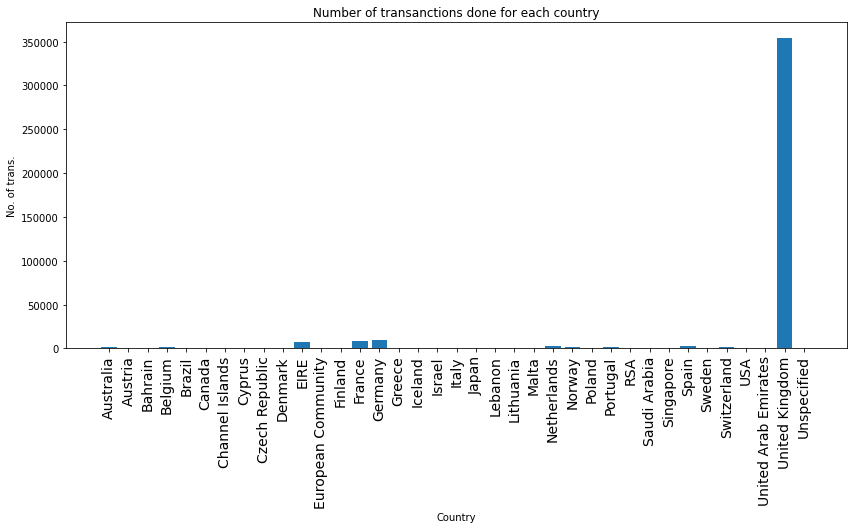

In [ ]:
plt.figure(figsize=(14,6))
plt.bar(list(df.groupby(['Country']).groups.keys()), df.groupby(['Country'])['CustomerID'].count())
plt.xticks(rotation = 90, fontsize = 14)
plt.title("Number of transanctions done for each country")
plt.ylabel("No. of trans.")
plt.xlabel("Country")
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]), <a list of 36 Text major ticklabel objects>)

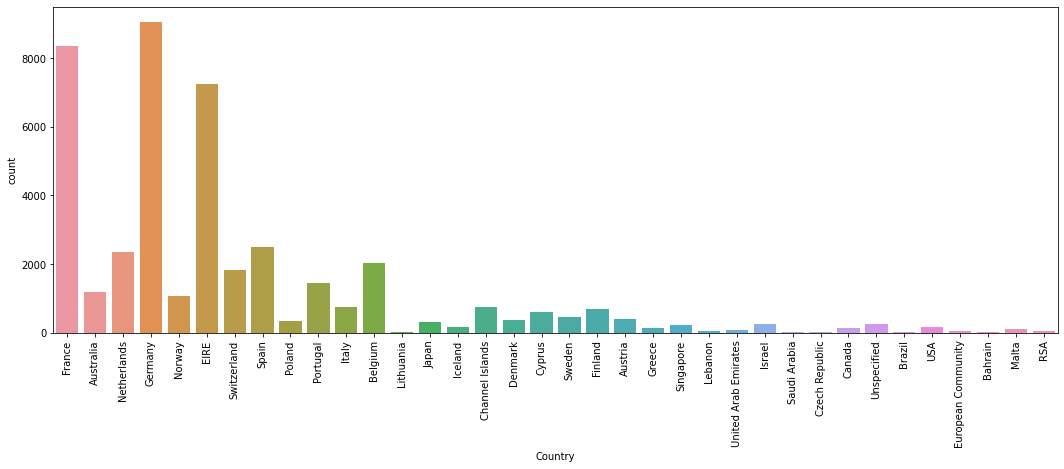

In [ ]:
plt.figure(figsize=(18,6))
sns.countplot(df[df['Country'] != 'United Kingdom']['Country'])
plt.xticks(rotation=90)

In [ ]:
info = pd.DataFrame(data = df.groupby(['Country'])['InvoiceNo'].nunique(), index=df.groupby(['Country']).groups.keys()).T
info

,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,EIRE,European Community,Finland,France,Germany,Greece,Iceland,Israel,Italy,Japan,Lebanon,Lithuania,Malta,Netherlands,Norway,Poland,Portugal,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
InvoiceNo,57,17,2,98,1,6,26,16,2,18,260,4,41,389,457,5,7,5,38,19,1,4,5,95,36,19,57,1,1,7,90,36,51,5,3,16649,8


Observations:
UK has done most of the transanctions. (19857)

Least amount of transanctions were made by countries like Brazil, RSA etc. (only 1)

#Checking out Each columns separately

In [ ]:
df['Description'].value_counts().head()

WHITE HANGING HEART T-LIGHT HOLDER    2028
REGENCY CAKESTAND 3 TIER              1724
JUMBO BAG RED RETROSPOT               1618
ASSORTED COLOUR BIRD ORNAMENT         1408
PARTY BUNTING                         1397
Name: Description, dtype: int64

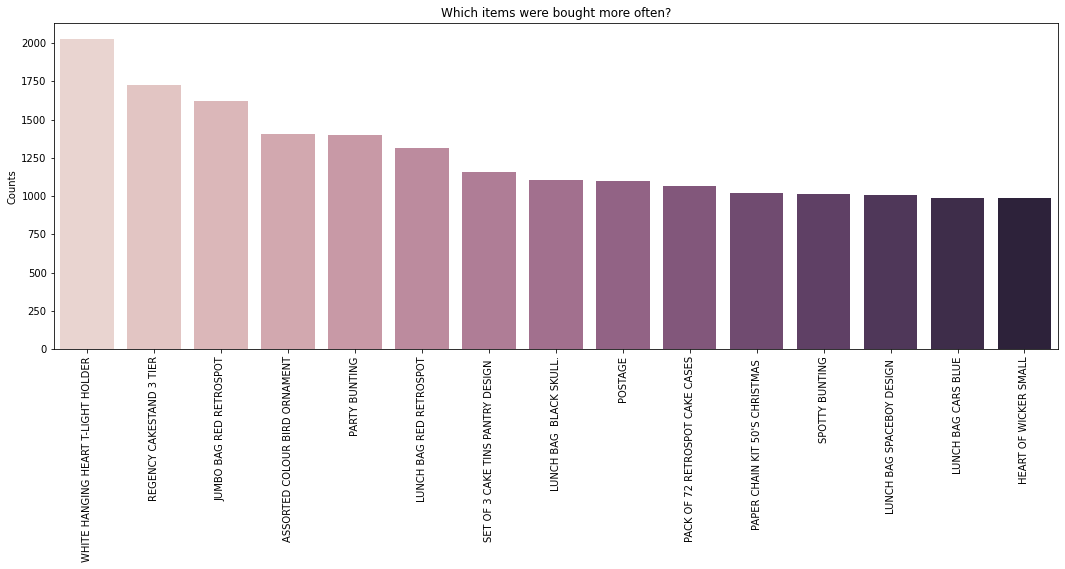

In [ ]:
item_counts = df['Description'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(item_counts.index, item_counts.values, palette=sns.cubehelix_palette(15))
plt.ylabel("Counts")
plt.title("Which items were bought more often?");
plt.xticks(rotation=90);

In [ ]:
df['StockCode'].value_counts().head()

85123A    2035
22423     1724
85099B    1618
84879     1408
47566     1397
Name: StockCode, dtype: int64

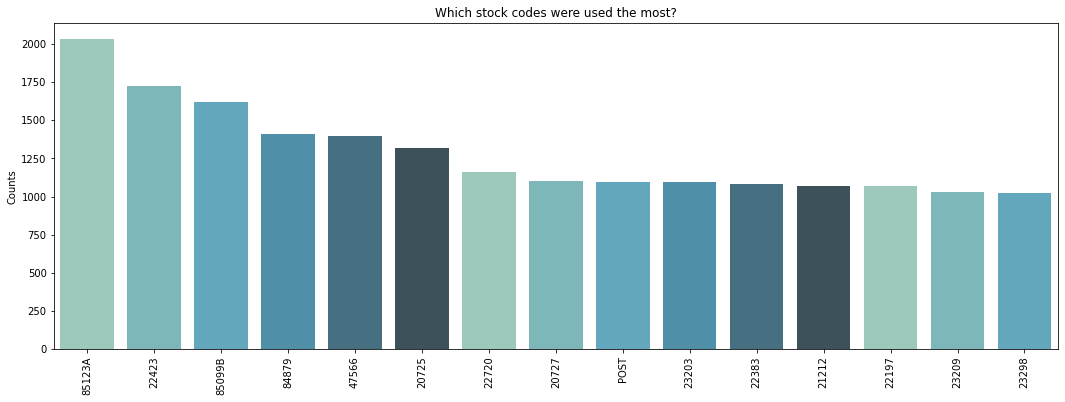

In [ ]:
stock_counts = df['StockCode'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(stock_counts.index, stock_counts.values, palette=sns.color_palette("GnBu_d"))
plt.ylabel("Counts")
plt.title("Which stock codes were used the most?");
plt.xticks(rotation=90);

In [ ]:
df['InvoiceNo'].value_counts().head()

576339    542
579196    533
580727    529
578270    442
573576    435
Name: InvoiceNo, dtype: int64

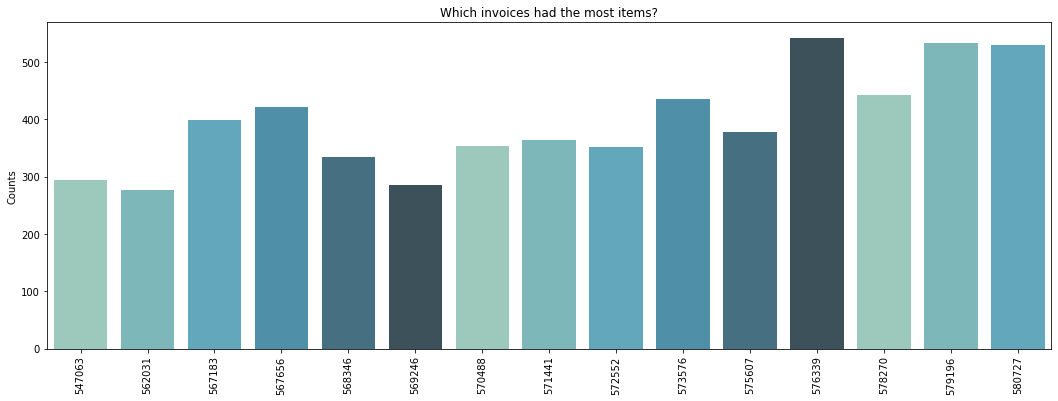

In [ ]:
inv_counts = df['InvoiceNo'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(inv_counts.index, inv_counts.values, palette=sns.color_palette("GnBu_d"))
plt.ylabel("Counts")
plt.title("Which invoices had the most items?");
plt.xticks(rotation=90);

In [ ]:
#which are the most expensive products?
df.sort_values("UnitPrice", ascending = False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
118352,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom
308846,573080,M,Manual,1,2011-10-27 14:20:00,4161.06,12536,France
308822,573077,M,Manual,1,2011-10-27 14:13:00,4161.06,12536,France
295254,571751,M,Manual,1,2011-10-19 11:18:00,3949.32,12744,Singapore
269591,569382,M,Manual,1,2011-10-03 16:44:00,3155.95,15502,United Kingdom


In [ ]:
df['UnitPrice'].value_counts().head()

1.25    45841
1.65    36834
2.95    26562
0.85    25968
0.42    21812
Name: UnitPrice, dtype: int64

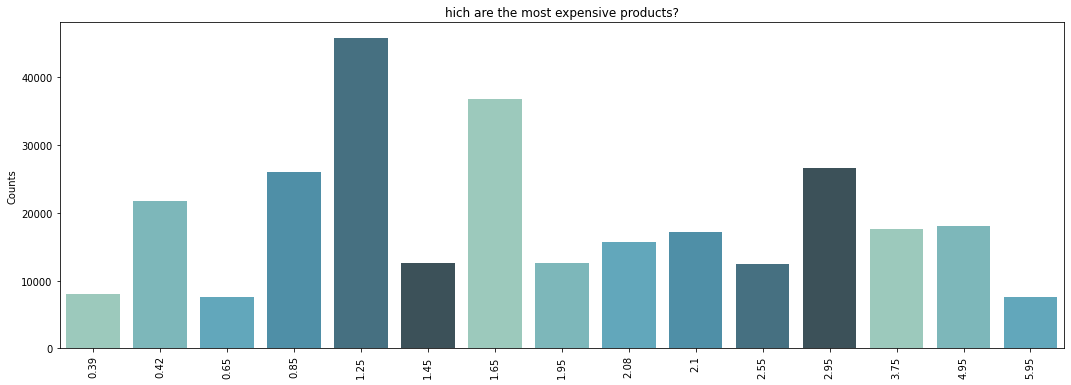

In [ ]:
unit_price = df['UnitPrice'].value_counts().sort_values(ascending=False).iloc[0:15]
plt.figure(figsize=(18,6))
sns.barplot(unit_price.index, unit_price.values, palette=sns.color_palette("GnBu_d"))
plt.ylabel("Counts")
plt.title("hich are the most expensive products?");
plt.xticks(rotation=90);

#Analyzing the Cancelled Order 

In [ ]:
pd.DataFrame([{
    'Customers': df.CustomerID.nunique(),
    'Products': df.StockCode.nunique(),
    'Transactions': df.InvoiceNo.nunique()
            }
]).rename(index = {0:"Num"})

,Customers,Products,Transactions
Num,4339,3665,18536


In [ ]:
customers = df.CustomerID.value_counts().sort_values(ascending=False)
print("99% of Users  Make {:.0f} Transactions, While Our Favourite Client Visits us {} times".
      format(np.round(customers.quantile(0.99)), customers.max()))

99% of Users  Make 668 Transactions, While Our Favourite Client Visits us 7847 times


In [ ]:
temp = df.groupby(by=['CustomerID','InvoiceNo'])['InvoiceDate'].count().reset_index()
temp = temp.rename(columns={'InvoiceDate':'Num. Products'})
temp.head(10)

,CustomerID,InvoiceNo,Num. Products
0,12346,541431,1
1,12347,537626,31
2,12347,542237,29
3,12347,549222,24
4,12347,556201,18
5,12347,562032,22
6,12347,573511,47
7,12347,581180,11
8,12348,539318,17
9,12348,541998,6


In [ ]:
df['orders cancelled'] = df['InvoiceNo'].apply(lambda x: int('C' in str(x)))
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,orders cancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0


In [ ]:
# Printing number of orders cancelled ->
print("Number of orders cancelled {}/{} ({:.2f}%)".format(df['orders cancelled'].sum(), df.shape[0], df['orders cancelled'].sum()/ df.shape[0] * 100))

Number of orders cancelled 0/397924 (0.00%)


In [ ]:
df.groupby(by=['StockCode', 'Description'])['orders cancelled'].count().sort_values(ascending=False).reset_index().head(10)

,StockCode,Description,orders cancelled
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2028
1,22423,REGENCY CAKESTAND 3 TIER,1724
2,85099B,JUMBO BAG RED RETROSPOT,1618
3,84879,ASSORTED COLOUR BIRD ORNAMENT,1408
4,47566,PARTY BUNTING,1397
5,20725,LUNCH BAG RED RETROSPOT,1316
6,22720,SET OF 3 CAKE TINS PANTRY DESIGN,1159
7,20727,LUNCH BAG BLACK SKULL.,1105
8,POST,POSTAGE,1099
9,21212,PACK OF 72 RETROSPOT CAKE CASES,1068


In [ ]:
df_n = df.copy(deep=True)

df_n['QuantityCancelled'] = 0
removeEntry = []; doubtEntry = []


for indexA, col in df.iterrows():
    if (col['Quantity'] > 0) or (col['Description'] == 'Discount'): continue
    temp = df.loc[(df['CustomerID'] == col['CustomerID']) &
                  (df['StockCode']  == col['StockCode'])  &
                  (df['InvoiceDate'] < col['InvoiceDate'])&
                  (df['Quantity']    >      0)].copy()
    
    ## Order Before Dec. 2010 and Cancelled after Dec 2010
    if(temp.shape[0]   == 0):
        doubtEntry.append(indexA)
    ## The real order exist
    elif(temp.shape[0] == 1):
        df_n.loc[temp.index[0], 'QuantityCancelled'] = -col['Quantity']
        removeEntry.append(indexA)
    
    ## Many real orders for such cancellation, will modify only the same Quantity, and remove the entry
    else:
        temp.sort_index(axis=0, ascending=False, inplace=True)
        for i, v in temp.iterrows():
            if v['Quantity'] < -col['Quantity'] : continue  ## cant cancel more than he bought
            df_n.loc[i, 'QuantityCancelled'] = -col['Quantity']
            removeEntry.append(indexA)
            break

In [ ]:
print('To be removed: {} with percentage {:.1f}%'.format(len(removeEntry), len(removeEntry) / df_n.shape[0] *100 ))
print('Waiting: {} with percentage {:.1f}%'.format(len(doubtEntry), len(doubtEntry) / df_n.shape[0] *100 ))

To be removed: 0 with percentage 0.0%
Waiting: 0 with percentage 0.0%


In [ ]:
df_n.drop(removeEntry, axis=0, inplace=True)
df_n.drop(doubtEntry, axis=0, inplace=True)

In [ ]:
## remaining Cancelled entries ... with unknown real records ... and not discounts
temp = df_n.loc[ (df['Quantity'] < 0) & (df['StockCode'] != 'D') ]
print("Rest of bad entries : {}".format(temp.shape[0]))
temp[:5]

Rest of bad entries : 0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,orders cancelled,QuantityCancelled


# We will now see the StockCode feature especially the discounted items:

In [ ]:
list_special_codes = df_n[df_n['StockCode'].str.contains('^[a-zA-Z]+', na = False, regex = True)]['StockCode'].unique()
list_special_codes

array(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

In [ ]:
for code in list_special_codes:
    print("{:<17} -> {:<35}".format(code, df_n[df_n['StockCode'] == code]['Description'].values[0]))

POST              -> POSTAGE                            
C2                -> CARRIAGE                           
M                 -> Manual                             
BANK CHARGES      -> Bank Charges                       
PADS              -> PADS TO MATCH ALL CUSHIONS         
DOT               -> DOTCOM POSTAGE                     


In [ ]:
df_n['QuantityCancelled'] = np.nan_to_num(df_n['QuantityCancelled'])
df_n.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,orders cancelled,QuantityCancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0


#Basket Price 

In [ ]:
df_n['TotalPrice'] = df_n['UnitPrice'] * (df_n['Quantity'] - df_n['QuantityCancelled'])
df_n.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,orders cancelled,QuantityCancelled,TotalPrice
37126,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,0,0,77183.60
10523,537626,22774,RED DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,0,0,15.00
314896,573511,22621,TRADITIONAL KNITTING NANCY,12,2011-10-31 12:25:00,1.65,12347,Iceland,0,0,19.80
314897,573511,23146,TRIPLE HOOK ANTIQUE IVORY ROSE,8,2011-10-31 12:25:00,3.29,12347,Iceland,0,0,26.32
314898,573511,23421,PANTRY HOOK SPATULA,12,2011-10-31 12:25:00,2.08,12347,Iceland,0,0,24.96


In [ ]:
temp = df_n.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice': 'Basket Price'})

df_n['InvoiceDate_int'] = df_n['InvoiceDate'].astype('int64')
temp = df_n.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_n.drop('InvoiceDate_int', axis = 1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
0,12346,541431,77183.60,2011-01-18 10:01:00.000000000
1,12347,537626,711.79,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,2011-08-02 08:48:00.000000000


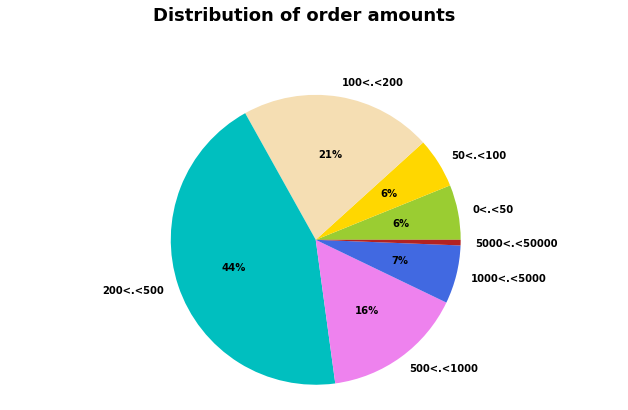

In [ ]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i,price in enumerate(price_range):
    if i==0:continue
    val = basket_price[(basket_price['Basket Price'] < price)&
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue', 'firebrick']
labels = ["{}<.<{}".format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels = labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle = 0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha = 'center', fontsize = 18)
plt.show()

 To check How many online customers are there in the dataset and what is their country of origin?

In [ ]:
print('From the dataset, the online retail shop has {} customers \
from {} different countries.'.format(len(df_data.CustomerID.unique()), len(df_data.Country.unique())))

From the dataset, the online retail shop has 4339 customers from 37 different countries.


To check What are the countries that are most represented in the dataset?

In [ ]:
ctm_cntry_df = df_data.groupby(['CustomerID', 'Country']).count().reset_index()

ctm_cntry_df = ctm_cntry_df.groupby('Country')['CustomerID'].count().reset_index().sort_values(
    by=['CustomerID'], ascending=False)

# Create a new column, Percentage to calculate the customer representation in percentage
ctm_cntry_df['Percentage']= np.round(ctm_cntry_df.CustomerID / ctm_cntry_df.CustomerID.sum() * 100, 2)

ctm_cntry_df.head(10)

,Country,CustomerID,Percentage
35,United Kingdom,3921,90.20
14,Germany,94,2.16
13,France,87,2.00
30,Spain,30,0.69
3,Belgium,25,0.58
32,Switzerland,21,0.48
26,Portugal,19,0.44
18,Italy,14,0.32
12,Finland,12,0.28
1,Austria,11,0.25


The output above, shows the top $10$ countries of that purchase from the online retail shop with the United Kingdom being the country with the highest customers. They represent about $90.18\%$ of the entire online customers.

Although $13$ online customers indicated that they were living in two countries, this does not significantly affect the values percetage values recorded. For these $13$ online customers, it may be that the countries recorded for their last purchases is where they are currently living.

In [ ]:
# Initialise a dict object. This is supposed to collect all customers who indicated more than 1 country
ctm_2_cntry = {} 

# for each index and customer id
for idx, cid in enumerate(df_data.CustomerID.unique()):
    
    # Get the country that the customer resides
    cntry = df_data[df_data.CustomerID == cid].Country.unique()
    
    # if customer has lived in more than 1 country
    if len(cntry) > 1: 
        
        # Update the ctm_2_cntry
        ctm_2_cntry[cid] = cntry

pd.DataFrame(ctm_2_cntry) # Create a pandas dataframe using ctm_2_cntry

,12431,12429,12370,12417,12422,12455,12457,12394
0,Australia,Denmark,Cyprus,Belgium,Australia,Cyprus,Switzerland,Belgium
1,Belgium,Austria,Austria,Spain,Switzerland,Spain,Cyprus,Denmark


In the two next cells, we group countries with customer percentage value less than or equal to $0.25$ together and then plot a pie chart.

In [ ]:
percent_margin = 0.25

# Create a new column, CountryCategory and set values to the corresponding values of the Country column
ctm_cntry_df['CountryCategory'] = ctm_cntry_df.Country

# Set Countries with Percentage less than or equal to percent_margin to 'Other Countries'

ctm_cntry_df.loc[ctm_cntry_df.Percentage <= percent_margin, 'CountryCategory'] = 'Other Countries'

ctm_cntry_df.head(11)

,Country,CustomerID,Percentage,CountryCategory
35,United Kingdom,3921,90.20,United Kingdom
14,Germany,94,2.16,Germany
13,France,87,2.00,France
30,Spain,30,0.69,Spain
3,Belgium,25,0.58,Belgium
32,Switzerland,21,0.48,Switzerland
26,Portugal,19,0.44,Portugal
18,Italy,14,0.32,Italy
12,Finland,12,0.28,Finland
1,Austria,11,0.25,Other Countries


In [ ]:
plot_data = [
    go.Pie(
        labels=ctm_cntry_df.CountryCategory,
        values=ctm_cntry_df.Percentage,
    )
]

plot_layout = go.Layout(
        title='Customer Country Count in Percentage.', 
            )

fig = go.Figure(
        data=plot_data, layout=plot_layout
    )
pyoff.iplot(fig)

In [ ]:
df_data['InvoiceYearMonth'] = df_data['InvoiceDate'].map(lambda date: 100*date.year + date.month)
df_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,201012
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,201012
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,201012


In [ ]:
df_data['Revenue'] = df_data.UnitPrice * df_data.Quantity
df_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,201012,20.34


In [ ]:
ctm_revenue = df_data.groupby('InvoiceYearMonth').Revenue.sum().reset_index()
ctm_revenue.head()

,InvoiceYearMonth,Revenue
0,201012,572713.890
1,201101,569445.040
2,201102,447137.350
3,201103,595500.760
4,201104,469200.361


In [ ]:
pd.DataFrame(ctm_revenue.Revenue.describe())

,Revenue
count,1.300000e+01
mean,6.854929e+05
std,2.234136e+05
min,4.471374e+05
25%,5.694450e+05
50%,6.000910e+05
75%,6.785946e+05
max,1.161817e+06


In [ ]:
plot_data = [
    go.Scatter(
        x=ctm_revenue['InvoiceYearMonth'],
        y=ctm_revenue['Revenue'],
    )
]

plot_layout = go.Layout(
        xaxis={"type": "category"},
        title='Montly Revenue from Dec. 2010 to Dec. 2011', 
        xaxis_title="Invoice Year-Month",
        yaxis_title="Monthly Revenue",
    )

fig = go.Figure(
        data=plot_data, 
        layout=plot_layout
    )

pyoff.iplot(fig)

From the graph figure above, we observe that the online retail shop made the highest sales in November 2011. Also, one can observe that, monthly sales rises after August.

Next, explore the percentage revenue generated by the retail shop based on the countries their customers reside.

In [ ]:
cntry_revenue_df = df_data.groupby(['Country']).Revenue.sum().reset_index().sort_values(by=['Revenue'], 
                                                                                        ascending=False)

cntry_revenue_df['Percentage'] = np.round(cntry_revenue_df.Revenue / cntry_revenue_df.Revenue.sum() * 100, 2)

cntry_revenue_df.head(5)

,Country,Revenue,Percentage
35,United Kingdom,7.308392e+06,82.01
23,Netherlands,2.854463e+05,3.20
10,EIRE,2.655459e+05,2.98
14,Germany,2.288671e+05,2.57
13,France,2.090240e+05,2.35


From the output above, the top $5$ countries with respect to revenue generated are:

* The United Kingdom
* The Republic of Ireland (EIRE)
* The Netherlands
* Germany
* France

with the United Kingdom recording the highest in percentage $(81.54\%)$.

In the next two cells, we update cntry_revenue_df with a new

In the two next cells, we group countries with revenue percentage value less than or equal to $0.25$ together and then plot a pie chart.

In [ ]:
percent_margin = 0.25

# Create a new column, CountryCategory and set values to the corresponding values of the Country column
cntry_revenue_df['CountryCategory'] = cntry_revenue_df.Country

# Set Countries with Percentage less than or equal to percent_margin to 'Other Countries'

cntry_revenue_df.loc[cntry_revenue_df.Percentage <= percent_margin, 'CountryCategory'] = 'Other Countries'

cntry_revenue_df.head(11)

,Country,Revenue,Percentage,CountryCategory
35,United Kingdom,7.308392e+06,82.01,United Kingdom
23,Netherlands,2.854463e+05,3.20,Netherlands
10,EIRE,2.655459e+05,2.98,EIRE
14,Germany,2.288671e+05,2.57,Germany
13,France,2.090240e+05,2.35,France
0,Australia,1.385213e+05,1.55,Australia
30,Spain,6.157711e+04,0.69,Spain
32,Switzerland,5.644395e+04,0.63,Switzerland
3,Belgium,4.119634e+04,0.46,Belgium
31,Sweden,3.837833e+04,0.43,Sweden


In [ ]:
plot_data = [
    go.Pie(
        labels=cntry_revenue_df.CountryCategory,
        values=cntry_revenue_df.Percentage,
    )
]

plot_layout = go.Layout(
        title='Country Revenue in Percentage', 
            )

fig = go.Figure(
        data=plot_data, layout=plot_layout
    )
pyoff.iplot(fig)

#RMF

Next, we will define some features and add them to the dataframe ctm_dt to build our machine learning model. We will use the Recency - Frequency - Monetary Value segmentation method. That is, we will put the customers into groups based on the following:

* Recency: Customers purchase behaviour based on their most recent purchase date and how many days they have been inactive since their last purchase.

* Frequency: Customers purchase behaviour based on the number of times they buy from the online retail shop.

* Monetary Value/Revenue: Customers purchase behaviour based the revenue they generate.

After we will apply K-means clustering to assign customers a score to each of the features.

In [ ]:
# now we will make another column AMOUNT which will store Spending of each Customer and we will sue the formula 
# As Amount = Quantity * Unit Price 

df['Amount'] = df['Quantity'] * df['UnitPrice']

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,orders cancelled,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,20.34


In [ ]:

'''
Recency is calulated as diffrence between Recent date and Last Invoice date (last purchase) 
Frequency is calculated as Unique values of Invoice Number (Bills)
Monetary value is calucated from Amount spent by customer
'''
import datetime as dt # for calculating recency 

c_date = dt.datetime(2011, 12, 11) # as maximum date in dataset is 10/12/2011 so we will set our current date as 11/12/2011

# Now we will create RFM modeling score for each customer

rfm_data = df.groupby('CustomerID').agg({
                        'InvoiceDate' : lambda x : (c_date - x.max()).days, 
                        'InvoiceNo' : lambda x : x.count(), 
                        'Amount' : lambda x : sum(x) })

# Now we will rename columns name to Recency, Frequency and Monetory
rfm_data.rename(columns = {
                        'InvoiceDate' : 'Recency', 
                        'InvoiceNo' : 'Frequency', 
                        'Amount' : 'Monetary' }, inplace = True)

# Now we will use resetindex to make sure that indexes are continuos.
rfm_data.reset_index(inplace = True)

In [ ]:
rfm_data.head(5)

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,3,182,4310.00
2,12348,76,31,1797.24
3,12349,19,73,1757.55
4,12350,311,17,334.40


In [ ]:
rfm_data.describe()

,CustomerID,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,15299.936852,93.041484,91.708689,2053.793018
std,1721.889758,100.007757,228.792852,8988.248381
min,12346.000000,1.000000,1.000000,0.000000
25%,13812.500000,18.000000,17.000000,307.245000
50%,15299.000000,51.000000,41.000000,674.450000
75%,16778.500000,142.500000,100.000000,1661.640000
max,18287.000000,374.000000,7847.000000,280206.020000


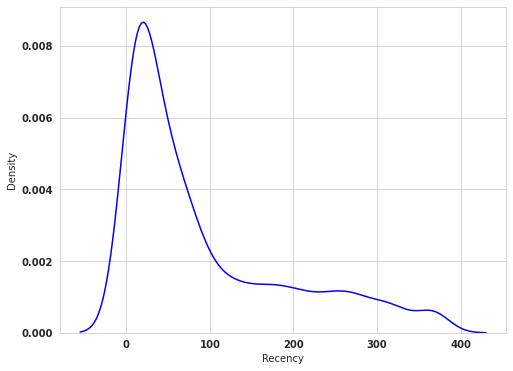

In [ ]:
# now we will see distribution of RFM dataset

sns.set_style('whitegrid')
plt.figure(figsize = (8, 6))

# plotting only Recency 
sns.distplot(rfm_data.Recency, hist = False, color = 'b')

# After plotting graph we infer that Recency is right skewed in rfm_dataset we will perform a necceasry transformation
# to normalize it.

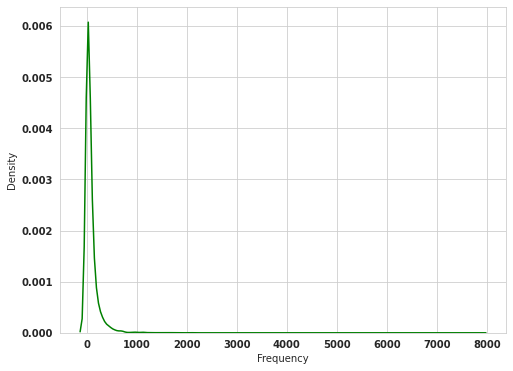

In [ ]:

sns.set_style('whitegrid')
plt.figure(figsize = (8, 6))

# plotting only Frequency 
sns.distplot(rfm_data.Frequency, hist = False, color = 'g')

# after ploting graph we infer that majority of frequnecy value has spike at mean so
# will check in decribe to see if any changes are requiered or not

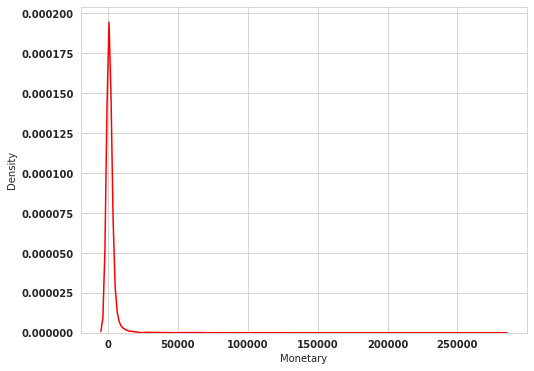

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize = (8, 6))

# plotting only Monetory

sns.distplot(rfm_data.Monetary, hist = False, color = 'r')

# After ploting we infer that its greaph is same as that of the Frquency and majority of its data is present near mean

In [ ]:
# Now we will divide customers into 4 segments on basis of their rfm_score for which we will create quantiles

quantiles = rfm_data.quantile(q = [0.25, 0.5, 0.75 ]) #using quantile function to get value of quantiles
quantiles = quantiles.to_dict() # coverting into dictionary for easier mapping 
quantiles

{'CustomerID': {0.25: 13812.5, 0.5: 15299.0, 0.75: 16778.5},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 100.0},
 'Monetary': {0.25: 307.24499999999995,
  0.5: 674.4499999999998,
  0.75: 1661.6400000000003},
 'Recency': {0.25: 18.0, 0.5: 51.0, 0.75: 142.5}}

In [ ]:
# Now we will assign  R and FM score to each category and customers
def R_score(val, param):
    if val <= quantiles[param][0.25]:   return 1
    elif val <= quantiles[param][0.50]: return 2
    elif val <= quantiles[param][0.75]: return 3
    else: return 4

def FM_score(val, param):
    if val <= quantiles[param][0.25]:   return 4
    elif val <= quantiles[param][0.50]: return 3
    elif val <= quantiles[param][0.75]: return 2
    else: return 1

# here we have used same ranking method for Frequency and Monetary because higher their value higher they are loyal to company
# while in case of RECENCY lower the value of recency higher they are loyal to company.  

#in short the lowest recency, highest frequency and monetary amounts are our best customers.

In [ ]:
rfm_data['R'] = rfm_data['Recency'].apply(lambda x : R_score(x, 'Recency')) # giving R score 
rfm_data['F'] = rfm_data['Frequency'].apply(lambda x : FM_score(x, 'Frequency')) # giving F score
rfm_data['M'] = rfm_data['Monetary'].apply(lambda x : FM_score(x, 'Monetary')) # giving M score

In [ ]:
rfm_data.head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M
0,12346,326,1,77183.60,4,4,1
1,12347,3,182,4310.00,1,1,1
2,12348,76,31,1797.24,3,3,1
3,12349,19,73,1757.55,2,2,1
4,12350,311,17,334.40,4,4,3
5,12352,37,85,2506.04,2,2,1
6,12353,205,4,89.00,4,4,4
7,12354,233,58,1079.40,4,2,2
8,12355,215,13,459.40,4,4,3
9,12356,23,59,2811.43,2,2,1


In [ ]:

# Now we will add 2 another columns for rfm_data which incude rfm_score and rfm_group which will further  show that to whcih
# group it will belong. 

rfm_data['Group'] = rfm_data.R.map(str) + rfm_data.F.map(str) + rfm_data.M.map(str) 

# here we will make a new column of score which will store the score of group by adding RFM scores
rfm_data['Score'] = rfm_data[['R', 'F', 'M']].sum(axis = 1)

rfm_data.head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,Group,Score
0,12346,326,1,77183.60,4,4,1,441,9
1,12347,3,182,4310.00,1,1,1,111,3
2,12348,76,31,1797.24,3,3,1,331,7
3,12349,19,73,1757.55,2,2,1,221,5
4,12350,311,17,334.40,4,4,3,443,11
5,12352,37,85,2506.04,2,2,1,221,5
6,12353,205,4,89.00,4,4,4,444,12
7,12354,233,58,1079.40,4,2,2,422,8
8,12355,215,13,459.40,4,4,3,443,11
9,12356,23,59,2811.43,2,2,1,221,5


In [ ]:
# Now we will assign the groups to the custoemers on basis of their RFM Score which we calcluated earlier 
# in our case we will make 4 groups i.e Platinum, gold, silver and Bronze which are Membership level to the company

Membership = ['Platinum', 'Gold', 'Silver', 'Bronze']  # assigning membership level for customers

Score_cuts = pd.qcut(rfm_data.Score, q = 4, labels = Membership) # get the score using pandas.qcut method

rfm_data['Membership'] = Score_cuts.values # assign the score cuts values to new column Membership

rfm_data.head(10) # pritns the head of dataset

,CustomerID,Recency,Frequency,Monetary,R,F,M,Group,Score,Membership
0,12346,326,1,77183.60,4,4,1,441,9,Silver
1,12347,3,182,4310.00,1,1,1,111,3,Platinum
2,12348,76,31,1797.24,3,3,1,331,7,Gold
3,12349,19,73,1757.55,2,2,1,221,5,Platinum
4,12350,311,17,334.40,4,4,3,443,11,Bronze
5,12352,37,85,2506.04,2,2,1,221,5,Platinum
6,12353,205,4,89.00,4,4,4,444,12,Bronze
7,12354,233,58,1079.40,4,2,2,422,8,Gold
8,12355,215,13,459.40,4,4,3,443,11,Bronze
9,12356,23,59,2811.43,2,2,1,221,5,Platinum


#Data Scaling 

In [ ]:
rfm_data.head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,Group,Score,Membership
0,12346,326,1,77183.60,4,4,1,441,9,Silver
1,12347,3,182,4310.00,1,1,1,111,3,Platinum
2,12348,76,31,1797.24,3,3,1,331,7,Gold
3,12349,19,73,1757.55,2,2,1,221,5,Platinum
4,12350,311,17,334.40,4,4,3,443,11,Bronze
5,12352,37,85,2506.04,2,2,1,221,5,Platinum
6,12353,205,4,89.00,4,4,4,444,12,Bronze
7,12354,233,58,1079.40,4,2,2,422,8,Gold
8,12355,215,13,459.40,4,4,3,443,11,Bronze
9,12356,23,59,2811.43,2,2,1,221,5,Platinum


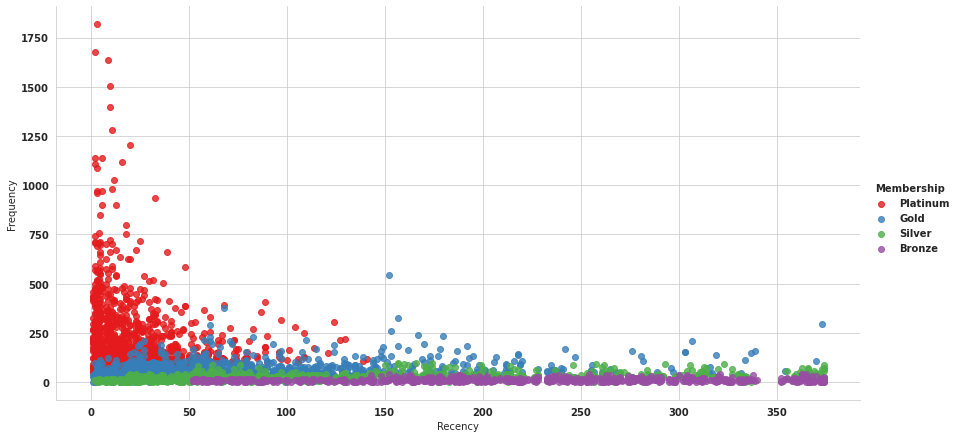

In [ ]:
dist = rfm_data[rfm_data.Frequency < 2000 ] # as most of the frequency value is less than 2000 

sns.lmplot(x = 'Recency', y = 'Frequency', hue = 'Membership', data = dist, palette = 'Set1', fit_reg = False, height = 6, aspect = 2)

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# now we will perform feature scaling on the datset, from the distribution plot which we plotted earlier we saw that our
# data is  right skewed and we need to perform suitable normalization technique to scale our data accordingly
# so we will use LOG TRANSFORM to scale our data. 

import math

# because log(0) in nan so we will hande it explicitly
# training dataset which only contain 3 features of RFM for finding optimal value of K in Kmeans
X_train = rfm_data.iloc[:, [1, 2, 3]]

# now we will apply changes to the X_training dataset instead of the original RFM dataset
X_train.Recency = rfm_data.Recency.apply(lambda x : 0 if x == 0 else round(math.log(x), 3)) 
X_train.Frequency = rfm_data.Frequency.apply(lambda x : 0 if x == 0 else round(math.log(x), 3))
X_train.Monetary = rfm_data.Monetary.apply(lambda x : 0 if x == 0 else round(math.log(x), 3))

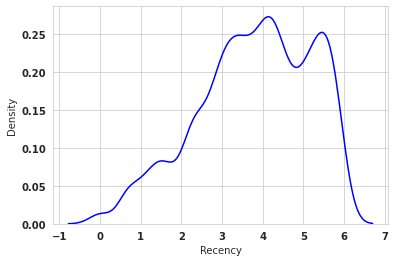

In [ ]:
sns.distplot(X_train['Recency'], hist = False, color = 'b')

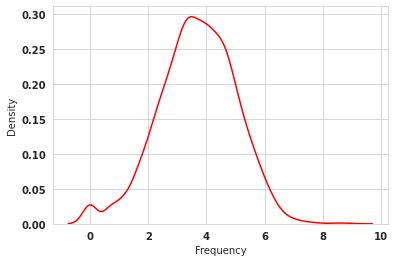

In [ ]:
sns.distplot(X_train['Frequency'], hist = False, color = 'r')

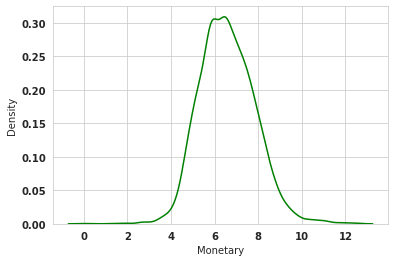

In [ ]:
sns.distplot(X_train['Monetary'], hist = False, color = 'g')

In [ ]:
# we will apply standard scaler to bring the dimension of X_train in same range
from sklearn.preprocessing import StandardScaler as scaler

sc = scaler() # create instance of Standardscaler

Scaled_Data = sc.fit_transform(X_train) # applying transformation to X_train

Scaled_Data = pd.DataFrame(Scaled_Data, index = rfm_data.index, columns = X_train.columns) # changing into dataframe again

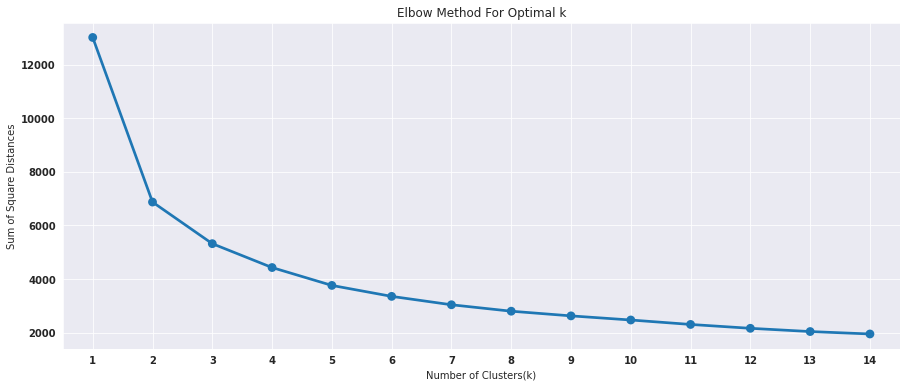

In [ ]:
# Now we will find the optimal value of k in Kmeans clustering using elbow method

from sklearn.cluster import KMeans

square_dist = [] # for storing square_distance after using Kmeans model
itr = [] # for storing iteration count 

for i in range(1, 15) : 
    model = KMeans(n_clusters = i, max_iter = 1000)
    model.fit(Scaled_Data)
    square_dist.append(model.inertia_)
    itr.append(i)

# now we will plot the graphical representaion of square distance and iterations
sns.set_style('darkgrid')
plt.figure(figsize = (15, 6))
sns.pointplot(itr, square_dist, col = 'b')
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

# After plotting we infer that there is sharp decrease / elbow formed when n_clusters are = 3 so we will
# create our final model using number of clusters equals to 3

In [ ]:
# Now we will build the model using K Means clustering. 
model = KMeans(n_clusters = 3, max_iter = 1000) # explicitly passing number of iterations

# fitting scaled dataset into our Kmeans Model
model.fit(Scaled_Data)

# adding cluster variable to the RFM dataset to check membership level of customer. 
rfm_data['Cluster'] = model.labels_ # labels_ returns the cluster of each datapoint (similar to y_pred).

rfm_data.head(5)

,CustomerID,Recency,Frequency,Monetary,R,F,M,Group,Score,Membership,Cluster
0,12346,326,1,77183.60,4,4,1,441,9,Silver,0
1,12347,3,182,4310.00,1,1,1,111,3,Platinum,2
2,12348,76,31,1797.24,3,3,1,331,7,Gold,0
3,12349,19,73,1757.55,2,2,1,221,5,Platinum,0
4,12350,311,17,334.40,4,4,3,443,11,Bronze,1


In [ ]:
# Now we will plot the ouput clusters values with corresponding RFM values
# We will assign the colour RED -> platinum class cluster(0), BLUE -> gold and silver cluster(1) , GREEN -> Bronze cluster(2)

rfm_data['Colour'] = rfm_data['Cluster'].apply(lambda x : 'Red' if x == 0 else ('Green' if x == 2 else 'Blue'))

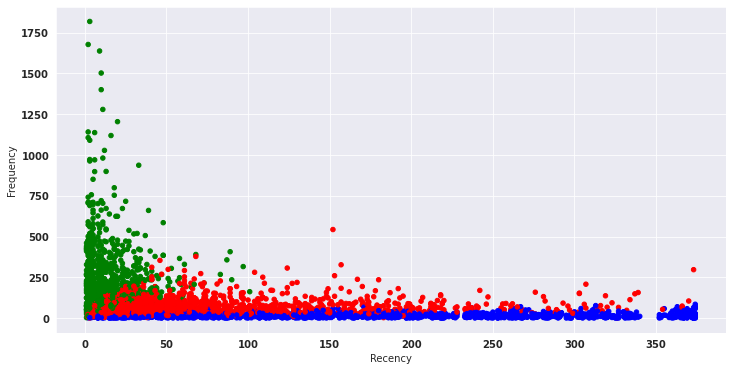

In [ ]:
# Now we will plot the colour value against RFM values which tells us about the cluster in which customer belongs to

dist = rfm_data[rfm_data.Frequency < 2000 ] # as most of the frequency value is less than 2000 

dist.plot(x = 'Recency', y = 'Frequency', kind = 'scatter', c = dist['Colour'], figsize = (12, 6))

#Let's find the first purchase made by each customer in the next quarter.

# Predicting Customer Purchase

The goal of this section is to come up with a make a model using the given dataframe df_data, to estimate if a given customer will buy something again from the retail shop in the next quarter.

The dataframe is split into two.

* The first sub-dataframe assigned to the Python variable ctm_bhvr_dt contains purchases made by customers from 01-12-2010 to 09-12-2011. This dataframe will be used to study the behavioural purchases of the online customers.

* The second sub-dataframe assigned to the Python variable ctm_next_quarter will be used to study the behavioural purchases of the customers in the next quarter. That is, from 01-12-2010 to 09-12-2011.

In [ ]:
ctm_bhvr_dt = df_data[(df_data.InvoiceDate < pd.Timestamp(2011,9,1)) & 
      (df_data.InvoiceDate >= pd.Timestamp(2010,12,1))].reset_index(drop=True)


ctm_next_quarter = df_data[(df_data.InvoiceDate < pd.Timestamp(2011,12,1)) & 
      (df_data.InvoiceDate >= pd.Timestamp(2011,9,1))].reset_index(drop=True)

In [ ]:
ctm_dt = pd.DataFrame(ctm_bhvr_dt['CustomerID'].unique())
ctm_dt.columns = ['CustomerID']
ctm_dt.head()

,CustomerID
0,17850
1,13047
2,12583
3,13748
4,15100


Let's find the first purchase made by each customer in the next quarter.

In [ ]:
# Create a dataframe with CustomerID and customers first purchase 
# date in ctm_next_quarter
ctm_1st_purchase_in_next_quarter = ctm_next_quarter.groupby('CustomerID').InvoiceDate.min().reset_index()
ctm_1st_purchase_in_next_quarter.columns = ['CustomerID','MinPurchaseDate']
ctm_1st_purchase_in_next_quarter.head()

,CustomerID,MinPurchaseDate
0,12347,2011-10-31 12:25:00
1,12348,2011-09-25 13:13:00
2,12349,2011-11-21 09:51:00
3,12352,2011-09-20 14:34:00
4,12356,2011-11-17 08:40:00


Let's find the last purchase made by each customer in the dataframe ctm_bhvr_dt.

In [ ]:
ctm_last_purchase_bhvr_dt = ctm_bhvr_dt.groupby('CustomerID').InvoiceDate.max().reset_index()
ctm_last_purchase_bhvr_dt.columns = ['CustomerID','MaxPurchaseDate']
ctm_last_purchase_bhvr_dt.head()

,CustomerID,MaxPurchaseDate
0,12346,2011-01-18 10:01:00
1,12347,2011-08-02 08:48:00
2,12348,2011-04-05 10:47:00
3,12350,2011-02-02 16:01:00
4,12352,2011-03-22 16:08:00


Let's merge the two dataframes ctm_last_purchase_bhvr_dt and ctm_1st_purchase_in_next_quarter.

In [ ]:
# Merge two dataframes ctm_last_purchase_bhvr_dt and ctm_1st_purchase_in_next_quarter
ctm_purchase_dates = pd.merge(ctm_last_purchase_bhvr_dt, ctm_1st_purchase_in_next_quarter, on='CustomerID', 
                              how='left')
ctm_purchase_dates.head()

,CustomerID,MaxPurchaseDate,MinPurchaseDate
0,12346,2011-01-18 10:01:00,NaT
1,12347,2011-08-02 08:48:00,2011-10-31 12:25:00
2,12348,2011-04-05 10:47:00,2011-09-25 13:13:00
3,12350,2011-02-02 16:01:00,NaT
4,12352,2011-03-22 16:08:00,2011-09-20 14:34:00


Let's calculate the time difference in days between customer's last purchase in the dataframe ctm_last_purchase_bhvr_dt and the first purchase in the dataframe ctm_1st_purchase_in_next_quarter.

In [ ]:
ctm_purchase_dates['NextPurchaseDay'] = (ctm_purchase_dates['MinPurchaseDate'] - ctm_purchase_dates['MaxPurchaseDate']).dt.days

ctm_purchase_dates.head()

,CustomerID,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,12346,2011-01-18 10:01:00,NaT,NaN
1,12347,2011-08-02 08:48:00,2011-10-31 12:25:00,90.0
2,12348,2011-04-05 10:47:00,2011-09-25 13:13:00,173.0
3,12350,2011-02-02 16:01:00,NaT,NaN
4,12352,2011-03-22 16:08:00,2011-09-20 14:34:00,181.0


In [ ]:
# merge with ctm_dt 
ctm_dt = pd.merge(ctm_dt, ctm_purchase_dates[['CustomerID','NextPurchaseDay']], on='CustomerID', how='left')
ctm_dt.head()

,CustomerID,NextPurchaseDay
0,17850,NaN
1,13047,70.0
2,12583,26.0
3,13748,136.0
4,15100,NaN


In [ ]:
ctm_dt.describe()

,CustomerID,NextPurchaseDay
count,3317.000000,1871.000000
mean,15284.195659,106.566007
std,1724.184899,77.683960
min,12346.000000,0.000000
25%,13799.000000,48.000000
50%,15245.000000,89.000000
75%,16770.000000,146.000000
max,18287.000000,364.000000


Update the dataframe ctm_dt by filling all missing values with $106$

In [ ]:
ctm_dt = ctm_dt.fillna(106)
ctm_dt.head()

,CustomerID,NextPurchaseDay
0,17850,106.0
1,13047,70.0
2,12583,26.0
3,13748,136.0
4,15100,106.0


Let us create a copy of the dataframe ctm_dt and apply the method get_dummies to it so as to convert all categorical column Segment to indicator variables.

In [ ]:
#create ctm_class as a copy of ctm_dt before applying get_dummies
ctm_class = ctm_dt.copy()
ctm_class = pd.get_dummies(ctm_class)
ctm_class.head()

,CustomerID,NextPurchaseDay
0,17850,106.0
1,13047,70.0
2,12583,26.0
3,13748,136.0
4,15100,106.0


Since our goal is to estimate whether a customer will make a purchase in the next quarter, we will create a new column NextPurchaseDayRange with values as either  1  or  0  defined as follows:

If the value is  1 , then it indicates that the customer will buy something in the next quarter, i.e.,  90  days from his or her last purchase.
The value  0  indicates that the customer will buy something in more than  90  days from his or her last purchase.

In [ ]:
ctm_class['NextPurchaseDayRange'] = 1  ## less than 3 months
ctm_class.loc[ctm_class.NextPurchaseDay>30,'NextPurchaseDayRange'] = 0 # more than 3 months
ctm_class.head()

,CustomerID,NextPurchaseDay,NextPurchaseDayRange
0,17850,106.0,0
1,13047,70.0,0
2,12583,26.0,1
3,13748,136.0,0
4,15100,106.0,0


# Building Machine Learning Models

In [ ]:
ctm_class = ctm_class.drop('NextPurchaseDay', axis=1)
X, y = ctm_class.drop('NextPurchaseDayRange', axis=1), ctm_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [ ]:
# Create an array of models
models = []
models.append(("LogisticRegression", LogisticRegression()))
models.append(("GaussianNB", GaussianNB()))
models.append(("RandomForestClassifier", RandomForestClassifier()))
models.append(("SVC", SVC()))
models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
models.append(("xgb.XGBClassifier", xgb.XGBClassifier(eval_metric='mlogloss')))
models.append(("KNeighborsClassifier", KNeighborsClassifier()))

In [ ]:
# Measuring the accuracy of the models
for model_abbrv, model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result = cross_val_score(model, X_train, y_train, cv = kfold, scoring = "accuracy")
    print(model_abbrv, cv_result)
    print()

LogisticRegression [0.92238131 0.91930618]

GaussianNB [0.92238131 0.91930618]

RandomForestClassifier [0.85983421 0.85143288]

SVC [0.92238131 0.91930618]

DecisionTreeClassifier [0.85908063 0.85143288]

xgb.XGBClassifier [0.92238131 0.91930618]

KNeighborsClassifier [0.91484552 0.913273  ]



From this result, we see that RandomForest Classifier is the overfitting, but LogisticRegression 

In [ ]:
log_RF_model = RandomForestClassifier().fit(X_train, y_train)
print('Accuracy of RandomForestClassifier on training set: {:.2f}'.format(log_RF_model.score(X_train, y_train)))
print('Accuracy of RandomForestClassifier on test set: {:.2f}'.format(log_RF_model.score(X_test[X_train.columns], y_test)))

Accuracy of RandomForestClassifier on training set: 1.00
Accuracy of RandomForestClassifier on test set: 0.87


Let's see how we could improve on the accuracy of the existing model LogisticRegression by finding suitable parameters. We will check if the improved LogisticRegression Classifier model outperforms the RandomForest

The LogisticRegression model gives us the following:

In [ ]:
LR_model = LogisticRegression().fit(X_train, y_train)
print('Accuracy of LogisticRegression classifier on training set: {:.2f}'.format(LR_model.score(X_train, y_train)))
print('Accuracy of LogisticRegression classifier on test set: {:.2f}'.format(LR_model.score(X_test[X_train.columns], y_test)))

Accuracy of LogisticRegression classifier on training set: 0.92
Accuracy of LogisticRegression classifier on test set: 0.92


In [ ]:
from sklearn.model_selection import GridSearchCV
import time

In [ ]:
dual=[True,False]
max_iter=[100,110,120,130,140,160]
C = [1.0,1.5,2.0,2.5,3.0]
param_grid = dict(dual=dual,max_iter=max_iter,C=C)

start_time = time.time()
LR = LogisticRegression(penalty='l2')

grid = GridSearchCV(
        estimator = LR, 
        param_grid = param_grid, 
        scoring='accuracy', 
        n_jobs=-1, 
        cv=3
    )

grid_result = grid.fit(X_train, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
grid.best_params_, grid.best_score_

Best Score:  0.9208443046927592
Best Params:  {'C': 1.0, 'dual': False, 'max_iter': 100}


({'C': 1.0, 'dual': False, 'max_iter': 100}, 0.9208443046927592)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
random = RandomizedSearchCV(
    estimator=LR, 
    param_distributions=param_grid, 
    cv = 3, 
    n_jobs=-1,
    scoring='accuracy'
)

start_time = time.time()
random_result = random.fit(X_train, y_train)
# Summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' ms')

In [ ]:
LR_model = LogisticRegression( 
                max_iter = list(random_result.best_params_.values())[0]-1, 
                C = list(random_result.best_params_.values())[-1]+4
            ).fit(X_train, y_train)
print('Accuracy of LogisticRegression classifier on training set: {:.2f}'.format(LR_model.score(X_train, y_train)))
print('Accuracy of LogisticRegression classifier on test set: {:.2f}'.format(LR_model.score(X_test[X_train.columns], y_test)))

As we can see, there is no improvement in LogisticRegression model
Let us go ahead and predict with these two models.

In [ ]:
log_RF_pred_y = log_RF_model.predict(X_test)

In [ ]:
LR_model_pred_y = LR_model.predict(X_test)

Let compute the confusion matrices of these two models with the user-defined function get_confusion_matrix defined below.

In [ ]:
def get_confusion_matrix(y_test, y_pred):
    """
    Displays the confusion matrix of the input numpy arrays y_test and y_pred.
    
    INPUT: 
        y_test - A numpy array 
        y_pred - A numpy array
        
    OUTPUT:
        NoneType
    """
    
    data = {'y_Actual': y_test, 'y_Predicted': y_pred}

    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    conf_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], 
                              rownames=['Actual'], 
                              colnames=['Predicted'])
    
    sns.heatmap(conf_matrix, annot=True, fmt = "d", cmap="Spectral")
    plt.show()

Let's get the confusion matrix for y_test and LR_pred_y, i.e., for the LogisticRegression classifier model and y_test and log_RF_model_y, i.e., for the RandomForest model.

In [ ]:
get_confusion_matrix(np.array(y_test), log_RF_pred_y)

In [ ]:
get_confusion_matrix(np.array(y_test), LR_model_pred_y)

Since we are concerned with accuracy of our model, we will choose the LogisticRegression model.

# Conclusion

In summary I observed the following:

From the dataset, the online retail shop has 5942 customers from 41 different countries.

The top 3 countries are the United Kingdom, Germany and France with the United Kingdom recording the $90.85\%$ of the customers of the online retail shop.

The online retail shop made the highest sales in November 2010, followed by November 2011. Also, there was a rise in monthly sales after August.

The online retail shop got most of it revenue from customers residing in the United Kingdom followed by The Republic of Ireland, The Netherlands, Germany and France.

Finally, we introduced new features into our dataframe, ctm_dt and we builded a machine learning model that will help us decide if customer will buy something again from the online shop in the next quarter, i.e., $90$ days from the date of his/her last purchase. Among the models that we used, we had to improve the XGB classifier model by the process of hyperparameter tuning to outperform the LogisticRegression model.

In [ ]:
from pickle import dump

In [ ]:
from pickle import load

In [ ]:
# save the model to disk
dump(LR_model, open('finalized_model.sav', 'wb'))

In [ ]:
#dump(log_RF_model,open('Final-Model.sav', 'wb'))

In [ ]:
loaded_model=load(open('finalized_model.sav', 'rb'))
result = loaded_model.score(X_test[X_train.columns],y_test)
print(result)

In [ ]:
ctm_class